# Apply community detection algorithms

## Import modules
for more information regarding the algorithms see:
- leidenalg (implementation of Leiden algorithm): https://github.com/vtraag/leidenalg
- ModularityPruning (pruning tool to identify small subsets of network partitions): http://github.com/ragibson/ModularityPruning

In [2]:
import numpy as np
import igraph as ig
from modularitypruning import prune_to_stable_partitions
from modularitypruning.leiden_utilities import repeated_parallel_leiden_from_gammas
from modularitypruning.champ_utilities import CHAMP_3D
from modularitypruning.parameter_estimation_utilities import domains_to_gamma_omega_estimates
from modularitypruning.plotting import plot_2d_domains_with_estimates
from modularitypruning.plotting import plot_estimates
from modularitypruning.champ_utilities import CHAMP_2D
from modularitypruning.parameter_estimation_utilities import ranges_to_gamma_estimates
from modularitypruning.plotting import plot_estimates
import matplotlib.pyplot as plt
import os
from random import seed
from python_helpers import print_partition  # our local helper scripts


from modularitypruning import prune_to_multilayer_stable_partitions
from modularitypruning.leiden_utilities import repeated_parallel_leiden_from_gammas_omegas
# import cairocffi # pip install cairocffi==0.6 // pip install pipwin pipwin install cairocffi
import scipy.io

SyntaxError: invalid syntax (2751597918.py, line 28)

## Leiden algorithm on aggregated multi-edge graph with ModularityPruning (Gibson and Mucha, 2022)

Community detection based on the single-layer multi-edge aggregated graph. Partitions are then pruned with ModularityPruning (http://github.com/ragibson/ModularityPruning) to keep only stable and modularity-optimal solutions.

Progress: [################################################################################] Time: 216.5 / 216.5 s
------------------------------------------------------------------------
PARTITION with 5 COMMUNITIES:
------------------------------------------------------------------------
GAMMA =  (0, 1, 0, 2, 1, 0, 1, 2, 1, 3, 1, 2, 3, 1, 3, 3, 1, 4, 3, 2, 4, 2, 0, 2, 2, 4, 3, 1, 0, 3, 3, 2, 2)
------------------------------------------------------------------------
COMMUNITY 0 with 5 nodes:
{'umweltschädlich', 'wartungsintensiv', 'Akzeptanz eines neuen Materialsystems', 'enthält Kunststoff', 'leicht zerstörbar'}
------------------------------------------------------------------------
COMMUNITY 1 with 8 nodes:
{'energieeffizient', 'nachhaltig', 'elektronikfrei', 'Energie   generierend', 'Energie   speichernd', 'energieautonom', 'ökologisch', 'umweltfreundlich'}
------------------------------------------------------------------------
COMMUNITY 2 with 9 nodes:
{'technologisch', 'aktive

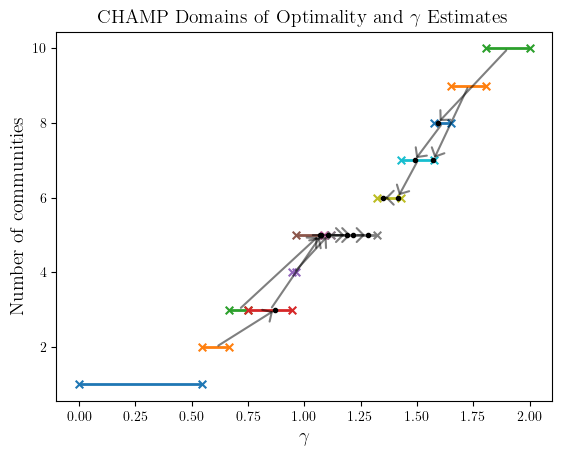

In [2]:
np.set_printoptions(threshold=np.inf)

with open("outputs/01_dataPreperation/final/CAMaggregated_adj_matrix.csv", "r") as f:
    names = f.readline()

names = names.split('" "')
names[0] = names[0][1:]     # strip the first "
names[-1] = names[-1][:-2]  # strip the last \n

names = dict(enumerate(names))

adj_matrix = np.loadtxt(open("outputs/01_dataPreperation/final/CAMaggregated_adj_matrix.csv", "rb"), delimiter=" ", skiprows=1)


# remove self-loops
np.fill_diagonal(adj_matrix, 0)

G = ig.Graph.Adjacency(matrix=adj_matrix, mode="undirected")

gamma_range = (0, 2)
leiden_gammas = np.linspace(*gamma_range, 10 ** 5) # 5   # 100k runs of Leiden algorithm

seed(12345)
np.random.seed(12345)
partitions = repeated_parallel_leiden_from_gammas(G, leiden_gammas)

# prune to the stable partitions from (gamma=0, omega=0) to (gamma=2, omega=2)
seed(12345)
np.random.seed(12345)
stable_parts = prune_to_stable_partitions(G, partitions, *gamma_range)

# run CHAMP to obtain the dominant partitions along with their regions of optimality
ranges = CHAMP_2D(G, partitions, gamma_0=0.0, gamma_f=2.0)

# append gamma estimate for each dominant partition onto the CHAMP domains
gamma_estimates = ranges_to_gamma_estimates(G, ranges)

# get some infos about our partitions
for stable_part in stable_parts:
    print_partition(stable_part, partitions, names, gamma_estimates)
    print("\n\n")



# plot gamma estimates and domains of optimality
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plot_estimates(gamma_estimates)
plt.title(r"CHAMP Domains of Optimality and $\gamma$ Estimates", fontsize=14)
plt.xlabel(r"$\gamma$", fontsize=14)
plt.ylabel("Number of communities", fontsize=14)
plt.savefig("outputs/02_analyses_CAMs/graphics/aggregatedCAM_Leiden.jpg", format="jpg") # specify filetype explicitly
plt.savefig("outputs/02_analyses_CAMs/graphics/aggregatedCAM_Leiden.tif", format="tif") # specify filetype explicitly
plt.show()
plt.close()

## Leiden algorithm on multilayer graph with ModularityPruning (Gibson and Mucha, 2022)

Community detection based on a multilayer graph with participants as layers. Partitions are then pruned with ModularityPruning (http://github.com/ragibson/ModularityPruning) to keep only stable and modularity-optimal solutions.

Progress: [################################################################################] Time: 1418.3 / 1418.3 s


c:\Users\fenn\AppData\Local\R-MINI~1\lib\site-packages\modularitypruning\parameter_estimation_utilities.py:129: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  p = fsolve(f, np.array([0.5]))[0] if pers < 1.0 and K > 1 else 1.0
c:\Users\fenn\AppData\Local\R-MINI~1\lib\site-packages\modularitypruning\parameter_estimation_utilities.py:129: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  p = fsolve(f, np.array([0.5]))[0] if pers < 1.0 and K > 1 else 1.0
c:\Users\fenn\AppData\Local\R-MINI~1\lib\site-packages\modularitypruning\parameter_estimation_utilities.py:129: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  p = fsolve(f, np.array([0.5]))[0] if pers < 1.0 and K > 1 else 1.0
c:\Users\fenn\AppData\Local\R-MINI~1\lib\site-packages\modularitypruning\para

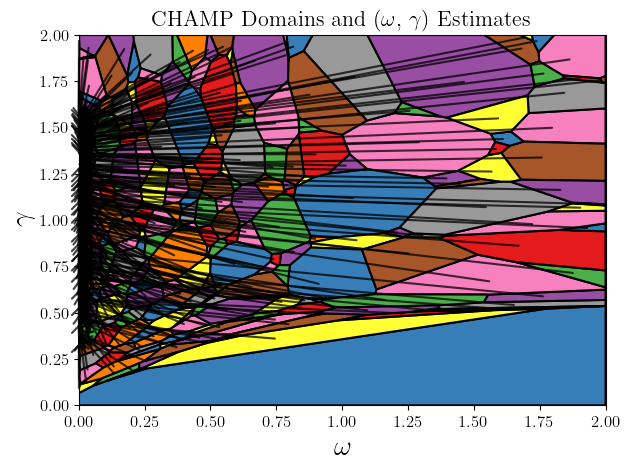

In [3]:
np.set_printoptions(threshold=np.inf)

# CAMaggregated = scipy.io.loadmat("outputs/01_dataPreperation/final/CAMaggregated_adj_matrices.mat") # !!!
CAMaggregated = scipy.io.loadmat("outputs/01_dataPreperation/final/CAMaggregated_adj_matrices_onlyOnes.mat") # !!!

# import names for labelling
with open("outputs/01_dataPreperation/final/CAMaggregated_adj_matrix.csv", "r") as f:
    names = f.readline()

names = names.split('" "')
names[0] = names[0][1:]     # strip the first "
names[-1] = names[-1][:-2]  # strip the last \n

names = dict(enumerate(names))

adj_matrices = list(CAMaggregated["multigraph_adj_matrices_list"][0,0])

num_layers = len(adj_matrices)
n_per_layer = 33

# nodes   0..32 are layer0
# nodes  33..65 are layer1
# ...

# layer_vec holds the layer membership of each node
# e.g. layer_vec[5] = 2 means that node 5 resides in layer 2 (the third layer)
layer_vec = [i // n_per_layer for i in range(n_per_layer * num_layers)]
interlayer_edges = [(n_per_layer * layer + v, n_per_layer * layer + v + n_per_layer)
                    for layer in range(num_layers - 1)
                    for v in range(n_per_layer)]


# intralayer edges: we need a list of tuples (i.e. edgelist)
# recode the node indices according to the scheme described above (33..65 is layer1 etc.).
# note that this is unweighted for now (could add weights to the igraph object)
intralayer_edges = []
for i, adj_matrix in enumerate(adj_matrices):
    conn_indices = np.where(adj_matrix)
    x_indices, y_indices = conn_indices
    x_indices += i * n_per_layer
    y_indices += i * n_per_layer
    edges = zip(*(x_indices, y_indices))
    intralayer_edges += edges


G_interlayer = ig.Graph(interlayer_edges)
G_intralayer = ig.Graph(intralayer_edges)
# remove the double edges we got from constructing the igraph objects with symmetric matrices
G_intralayer = G_intralayer.simplify()

# run Leiden on a uniform 32x32 grid (1024 samples) of gamma and omega in [0, 2]
gamma_range = (0, 2)
omega_range = (0, 2)
leiden_gammas = np.linspace(*gamma_range, 32)
leiden_omegas = np.linspace(*omega_range, 32)

seed(12345)
parts = repeated_parallel_leiden_from_gammas_omegas(G_intralayer, G_interlayer, layer_vec, gammas=leiden_gammas, omegas=leiden_omegas)


# prune to the stable partitions from (gamma=0, omega=0) to (gamma=2, omega=2)
seed(12345)
stable_parts = prune_to_multilayer_stable_partitions(G_intralayer, G_interlayer, layer_vec,
                                                     "multiplex", parts,
                                                     *gamma_range, *omega_range)

# run CHAMP to obtain the dominant partitions along with their regions of optimality
seed(12345)
domains = CHAMP_3D(G_intralayer, G_interlayer, layer_vec, parts,
                   gamma_0=gamma_range[0], gamma_f=gamma_range[1],
                   omega_0=omega_range[0], omega_f=omega_range[1])



# append resolution parameter estimates for each dominant partition onto the CHAMP domains
seed(12345)
domains_with_estimates = domains_to_gamma_omega_estimates(G_intralayer, G_interlayer, layer_vec,
                                                          domains, model='multiplex')
for partition in stable_parts:
    print_partition(partition, parts, names, domains_with_estimates, type="multilayer")


# plot resolution parameter estimates and domains of optimality
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plot_2d_domains_with_estimates(domains_with_estimates, xlim=omega_range, ylim=gamma_range)
plt.title(r"CHAMP Domains and ($\omega$, $\gamma$) Estimates", fontsize=16)
plt.xlabel(r"$\omega$", fontsize=20)
plt.ylabel(r"$\gamma$", fontsize=20)
plt.gca().tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.savefig("outputs/02_analyses_CAMs/graphics/multilayerCAM_Leiden.jpg", format="jpg") # specify filetype explicitly
plt.savefig("outputs/02_analyses_CAMs/graphics/multilayerCAM_Leiden.tif", format="tif") # specify filetype explicitly
plt.show()
plt.close()